# Individual Project Planning Report
**Topic:** Predicting Player Activity on a Minecraft Research Server  
**Student:** Amanda Kwan, 35246966  
**Data sets:** players.csv, sessions.csv

## Data description
The data come from a Minecraft research server. Two related datasets are provided: 
- **players.csv** - 196 observations and 7 variables (age, gender, played_hours etc.)
- **sessions.csv** - 1535 observations and 5 variables (start_time, end_time, hashedEmail etc.)

Each player is identified by a unique 'hashedEmail' key that links the two datasets. I will join the datasets by 'hashedEmail' and calculate how many play sessions each player completed. Possible issues include missing data, different levels of experience categories, and players who may have no sessions.

In [1]:
# Loading libraries
library(tidyverse)
library(repr)

# Reading the data through a relative path
players <- read_csv("../data/players.csv")
sessions <- read_csv("../data/sessions.csv")

# Counting sessions per player
session_counts <- sessions |>
    group_by(hashedEmail) |>
    summarise(num_sessions = n())

# Joining players and session counts
data_joined <- left_join(players, session_counts, by = "hashedEmail")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimite

## Summary Statistics

To describe the quantitative variables in the data, I calculated the mean for each numeric column. These variables include player age, total hours played, and the number of play sessions recorded for each player. The average age of players provides a general idea of the demographic using the platform, while the average number of sessions and play hours represent overall player engagement levels. These summary statistics give a quick overview of the central tendencies in the dataset before visual analysis.

In [2]:
# Computing mean values
summary_means <- data_joined |>
    summarise(
        mean_age = mean(Age, na.rm = TRUE),
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        mean_num_sessions = mean(num_sessions, na.rm = TRUE)
        )
summary_means

mean_age,mean_played_hours,mean_num_sessions
<dbl>,<dbl>,<dbl>
21.13918,5.845918,12.28


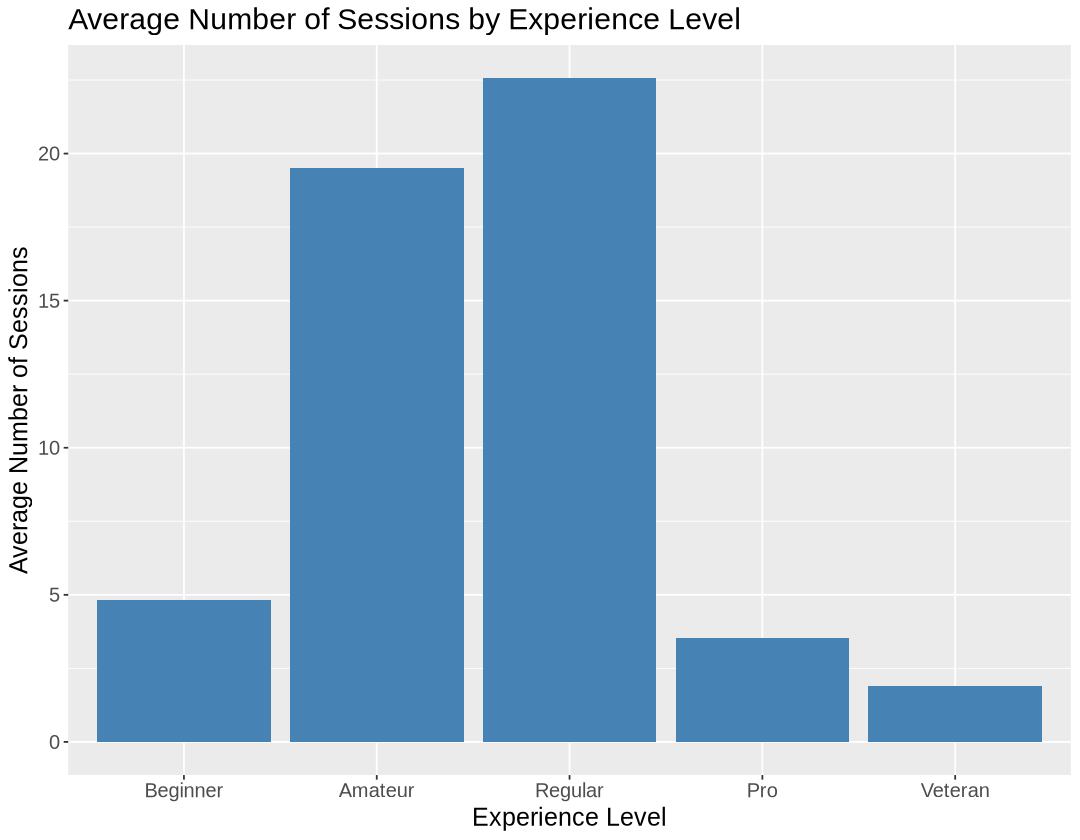

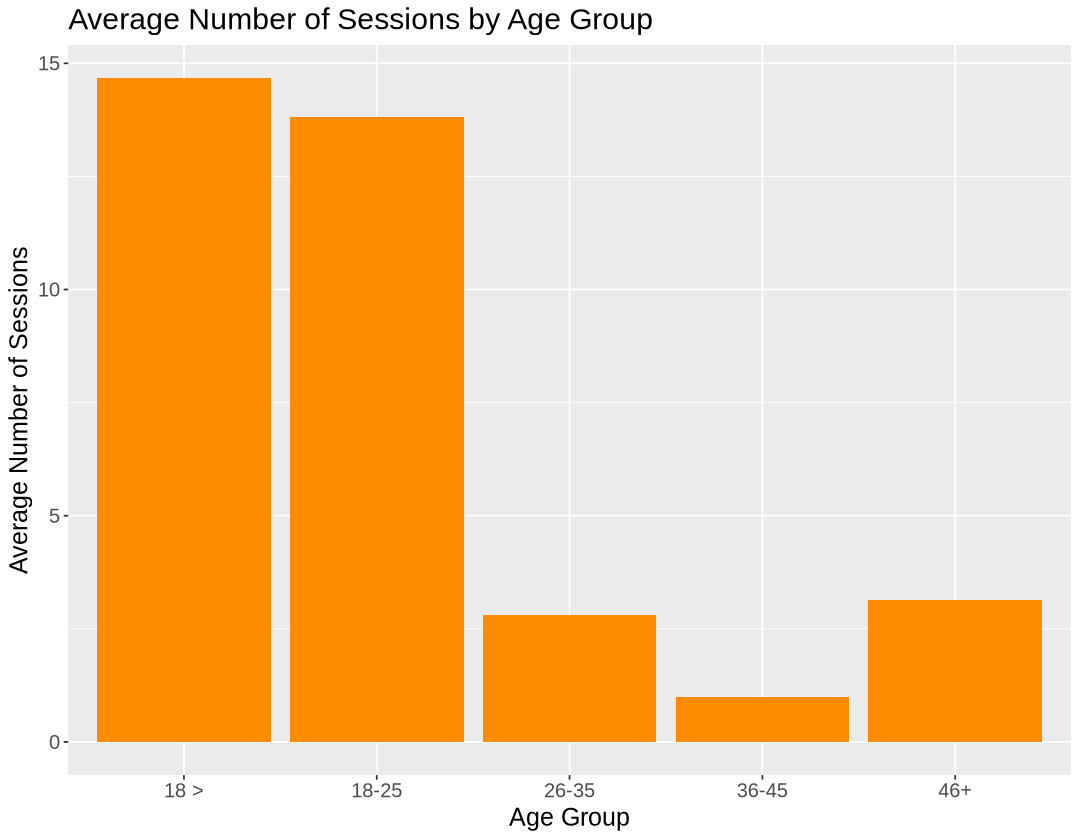

In [3]:
# Computing mean number of sessions per experience level
sessions_by_exp <- data_joined |>
    mutate(experience = fct_relevel(experience, "Beginner", "Amateur", "Regular", "Pro", "Veteran")) |>
    group_by(experience) |>
    summarise(mean_sessions = mean(num_sessions, na.rm = TRUE))

# Bar plot of sessions per experience level
options(repr.plot.width = 9, repr.plot.height = 7)
exp_plot <- ggplot(sessions_by_exp, aes(x = experience, y = mean_sessions)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(
        title = "Average Number of Sessions by Experience Level",
        x = "Experience Level",
        y = "Average Number of Sessions") +
    theme(text = element_text(size = 15))
exp_plot

# Bar plot of sessions per age group
age_plot <- data_joined |>
    mutate(age_group = case_when(
        Age < 18 ~ "18 >",
        Age < 26 ~ "18-25",
        Age < 36 ~ "26-35",
        Age < 46 ~ "36-45",
        TRUE ~ "46+"
        )) |>
    group_by(age_group) |>
    summarise(mean_num_sessions = mean(num_sessions, na.rm = TRUE)) |>
    ggplot(aes(x = age_group, y = mean_num_sessions)) +
    geom_bar(stat = "identity", fill = "darkorange") +
    labs(
        title = "Average Number of Sessions by Age Group",
        x = "Age Group",
        y = "Average Number of Sessions") +
    theme(text = element_text(size = 15))
age_plot

## Interpretation of Plots

The first plot shows that experience level is related to player activity. Average sessions counts increase from Beginners to Regular players, but then drop off for Pros and Veterans. The plot suggests that on average, intermediate players are the most engaged.

The second plot shows how average sessions vary across age groups. Younger players (especially those from age 18 and younger to age 25) tend to play much more often than older players. Engagement steadily decreases with age, suggesting that younger players are more active on the platform overall.

Together, these plots suggest that both experience and age influence player activity. These patterns provide useful context for later modeling as they show that these variables can be used to reliably predict player engagement.

## Questions

**Broad Question:**
Which kinds of players are most likely to contribute a large amount of play data to the server?

**Specific Question:**
Can we predict the number of sessions a player completes using their age, experience level, and gender?

## Methods and Plan

For the project, the plan is to model 'num_sessions' (the number of sessions completed by each player) using KNN regression. KNN is appropriate because it is a simple, non-parametric method that can capture non-linear relationships between predictors and the response variable. Since our EDA suggests that player activity increases and then decreases with experience, KNN can model this kind of non-linear trend without needing to specify a functional form in advance.

KNN doesn't rely on strong assumptions about the data distribution/linearity, which makes it flexible. However, its main limitations are that it can perform poorly if features are on different scales or if there are many irrelevant predictors. We will compare KNN to a linear regression model as a baseline that assumes a straight-line relationship between predictors and the response. If linear regression performs similarly, it may be preferred for its interpretability.

Before modeling, we will process the data to ensure it is tidy. Numeric variables (like age) will be scaled so that all predictors contribute equally to distance calculations. We will then split the data into 70% training and 30% testing sets to evaluate model performance on unseen data. Finally, we will use cross-validations on the training data to tune 'k', selecting the value that minimizes RMSE. The final model will be evaluated using RMSPE.

## GitHub Repository Link
https://github.com/ajkwan16/dsci-100-project-individual.git